In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

/Users/lady6493/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Demonstration of Ball Hit Algorithm (included within ball_tracker.py)

In [2]:
# read the pickle file
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [3]:
ball_positions = [x.get(1,[]) for x in ball_positions]
# convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [4]:
df_ball_positions

,x1,y1,x2,y2
0,873.804382,637.854004,893.527039,659.235596
1,873.804382,637.854004,893.527039,659.235596
2,873.804382,637.854004,893.527039,659.235596
3,859.473083,644.068787,881.885925,667.882019
4,847.160095,657.816772,867.828674,679.926147
...,...,...,...,...
209,1183.088013,244.789673,1201.911011,267.016876
210,1183.361694,229.766510,1198.938843,246.854187
211,1181.428467,223.232864,1197.133789,242.714325
212,1178.809814,212.062424,1196.307129,231.119675


Text(0.5, 0, 'Time')

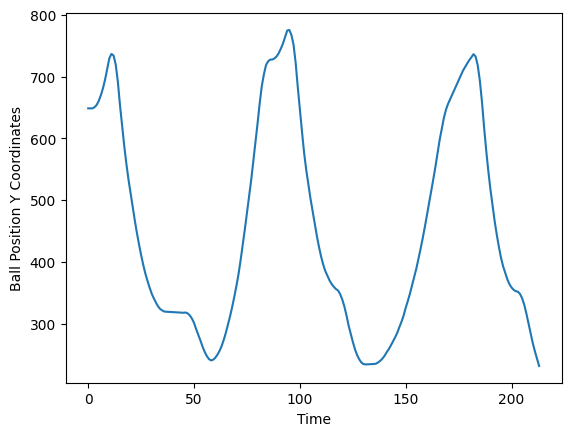

In [7]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2 # gets the middle of y
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean() # Remove outliers with rolling mean

# plot mid_y_rolling_mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])
plt.ylabel("Ball Position Y Coordinates")
plt.xlabel("Time")

Text(0.5, 0, 'Time')

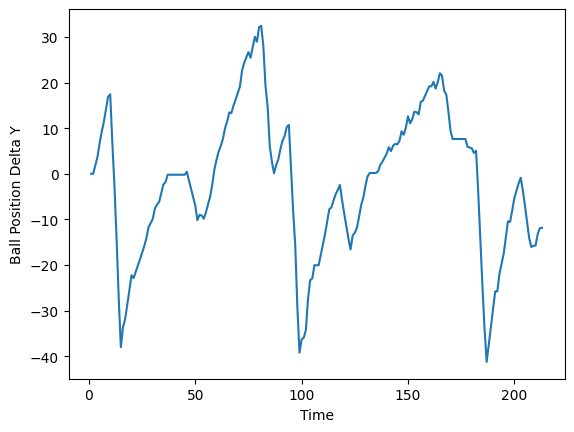

In [9]:
# Find when ball is being hit with change in delta y
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff() # Subtract consecutive rows
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['delta_y'])
plt.ylabel("Ball Position Delta Y")
plt.xlabel("Time")

In [10]:
df_ball_positions['ball_hit']=0

minimum_change_frames_for_hit = 25 # so change in Delta y is at least 25 frames
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ): # Loop over ball positions with buffer 1.2
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0 # iloc gets row i, looking for increasing then decreasing gradient
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0 # decreasing then increasing

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            # Look for gradient change in following frame
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        # Find ball hit positions
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

df_ball_positions[df_ball_positions['ball_hit']==1] # Find frames when hit

/var/folders/xx/2c3tbzpd13lfb8kc_92507pc0000gq/T/ipykernel_27748/1349191374.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1
/var/folders/xx/2c3tbzpd13lfb8kc_92507pc0000gq/T/ipykernel_27748/1349191374.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1
/var/folders/xx/2c3tbzpd13lfb8kc_92507pc0000gq/T/ipykernel_27748/1349191374.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,775.847900,716.625366,799.084717,740.501770,728.563568,736.586700,6.779999,1
58,921.870667,233.834702,941.795837,254.730423,244.282562,240.934303,-2.323087,1
95,623.544830,748.833557,642.153900,769.069183,758.951370,775.403607,1.074539,1
131,715.633789,225.659042,732.342224,243.887695,234.773369,234.433216,-0.578746,1
182,1295.490601,739.612976,1314.540527,760.089294,749.851135,736.167868,5.063983,1
